In [1]:
import numpy as np
import math
import pathlib
from matplotlib import pyplot as plt
import pydpf
import torch
from data_prep import prepare_data
import model
import neural_networks
import training
import time
import pandas as pd
import datetime
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import os


## Prepare data

In [2]:
#prepare_data(device)

In [3]:
observation_encoding_size = 128
state_encoding_size = 64
scaling = 1000.
DPF_types = ['DPF', 'Soft', 'Stop-Gradient', 'Marginal Stop-Gradient', 'Optimal Transport', 'Kernel']
deterministic = False
if deterministic:
    results_file = 'deep_mind_maze_results.csv'
else:
    results_file = 'nondeterministic_deep_mind_maze_results.csv'

In [4]:
def flatten_gens(list_of_gens):
    return [item for gen in list_of_gens for item in gen]
    
def is_in_it(item, it):
    return any(id(item) == id(item_) for item_ in it)
    

def get_SSM():
    encoder = neural_networks.ObservationEncoder(observation_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.3)
    decoder = neural_networks.ObservationDecoder(observation_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.3)
    state_encoder = neural_networks.StateEncoder(state_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.6)
    observation_partial_flows = [neural_networks.RealNVP_cond(dim = observation_encoding_size, hidden_dim=observation_encoding_size, condition_on_dim=state_encoding_size, generator = cuda_gen, zero_i=True), neural_networks.RealNVP_cond(dim = observation_encoding_size, hidden_dim=observation_encoding_size, condition_on_dim=state_encoding_size, generator = cuda_gen, zero_i=True)]
    flow_cov = torch.nn.Parameter(torch.eye(observation_encoding_size, device=device)*1, requires_grad=False)
    observation_flow = neural_networks.NormalizingFlowModel_cond(pydpf.MultivariateGaussian(torch.zeros(observation_encoding_size, device=device), cholesky_covariance= flow_cov, diagonal_cov=True, generator=cuda_gen), observation_partial_flows, device)
    observation_model = model.MazeObservation(observation_flow, encoder, decoder, state_encoder, device=device)
    dynamic_cov = torch.diag(torch.tensor([30/(scaling), 30/(scaling), 0.1], device=device))
    dynamic_model = model.MazeDynamic(cuda_gen, dynamic_cov)
    #proposal_partial_flows = [neural_networks.RealNVP_cond(dim = 3, hidden_dim=32, condition_on_dim=observation_encoding_size, generator=cuda_gen, zero_i=True), neural_networks.RealNVP_cond(dim = 3, hidden_dim=32, condition_on_dim=observation_encoding_size, generator=cuda_gen, zero_i=True)]
    #proposal_flow = neural_networks.NormalizingFlowModel_cond(None, proposal_partial_flows, device)
    #proposal_model = model.MazeProposal(proposal_flow, dynamic_model)
    prior_model = model.MazePrior(2*1000/scaling, 1.3*1000/scaling, cuda_gen)
    encoder_parameters = flatten_gens([encoder.parameters(), state_encoder.parameters(), decoder.parameters()])
    #flow_parameters = flatten_gens([observation_flow.parameters(), proposal_flow.parameters(), prior_model.parameters()])
    flow_parameters = flatten_gens([observation_flow.parameters(), prior_model.parameters()])
    SSM = pydpf.FilteringModel(dynamic_model=dynamic_model, prior_model=prior_model, observation_model=observation_model)
    print(f'observation encoder ps {sum(p.numel() for p in encoder.parameters())}')
    print(f'state encoder ps {sum(p.numel() for p in state_encoder.parameters())}')
    print(f'decoder ps {sum(p.numel() for p in decoder.parameters())}')
    print(f'observation flow ps {sum(p.numel() for p in observation_flow.parameters())}')
    #print(f'proposal flow ps {sum(p.numel() for p in proposal_flow.parameters())}')
    return SSM, encoder_parameters, flow_parameters, [flow_cov]
            

In [5]:
def transform_control(control, **data):
    output = control/torch.tensor([[[scaling, scaling, 1.]]], device=device)
    return output
    

In [6]:
def normalise_obs(observation, **data):
    return (observation - torch.mean(observation))/torch.std(observation)
    

In [7]:
def get_DPF(SSM):
    if DPF_type == 'DPF':
        return pydpf.DPF(SSM=SSM, resampling_generator=cuda_gen)
    if DPF_type == 'Soft':
        return pydpf.SoftDPF(SSM=SSM, resampling_generator=cuda_gen)
    if DPF_type == 'Stop-Gradient':
        return pydpf.StopGradientDPF(SSM=SSM, resampling_generator=cuda_gen)
    if DPF_type == 'Marginal Stop-Gradient':
        return pydpf.MarginalStopGradientDPF(SSM=SSM, resampling_generator=cuda_gen)
    if DPF_type == 'Optimal Transport':
        return pydpf.OptimalTransportDPF(SSM=SSM, regularisation=1.)
    if DPF_type == 'Kernel':
        kernel = pydpf.KernelMixture([('Gaussian', 3)], gradient_estimator='reparameterisation', generator=cuda_gen)
        return pydpf.KernelDPF(SSM=SSM, kernel=kernel)
    raise ValueError('DPF_type should be one of the allowed options')

In [8]:
with pydpf.utils.set_deterministic_mode(deterministic, True):
    for DPF_type in DPF_types:
        total_MSE = 0
        total_time = 0
        for i in range(5):
            cuda_gen = torch.Generator(device=device).manual_seed(i*10)
            SSM, encoder_params, flow_params, flow_cov = get_SSM()
            dpf = get_DPF(SSM)
            dpf.to(device)
            if DPF_type == 'Kernel':
                opt = torch.optim.AdamW([{'params': encoder_params, 'lr': 0.005}, {'params': flow_params, 'lr': 0.001}, {'params': dpf.resampler.mixture.parameters(), 'lr': 0.001, 'weight_decay': 0}], weight_decay=1e-3, betas=(0.7, 0.98), eps=1e-9)
            else:
                opt = torch.optim.AdamW([{'params': encoder_params, 'lr': 0.005}, {'params': flow_params, 'lr': 0.001}], weight_decay=1e-2, betas=(0.8, 0.99), eps=1e-9)
            opt_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)
            data = pydpf.StateSpaceDataset(data_path= pathlib.Path('.').parent.absolute().joinpath('data/maze_data.csv'), state_prefix='state', control_prefix='control', device = device)
            data.apply(normalise_obs,  'observation')
            scaling_tesnor = torch.tensor([[[scaling, scaling, 1.]]], device=device)
            data.apply(lambda state, **data: (state - torch.tensor([[[1000., 650., 0.]]], device=device))/scaling_tesnor, 'state')
            data.apply(transform_control, 'control')
            print('Data Loaded')
            start_time = time.time()
            test_mse, _ = training.train(dpf, opt, data, 100, (100, 100, 100), (64, 64, 64), (0.45, 0.2, 0.35), (1., 1., 1.), torch.Generator().manual_seed(i*10), None, 'MSE', 99, pre_train_epochs=0, device=device, lr_scheduler=opt_scheduler, state_scaling = scaling)
            total_MSE += test_mse
            total_time += time.time() - start_time
        MSE = total_MSE / 5
        runtime = total_time/5
        result_path = pathlib.Path('.').parent.absolute().joinpath(results_file)
        results = pd.read_csv(result_path, index_col=0)
        row = [str(datetime.timedelta(seconds=runtime)), math.sqrt(MSE)]
        results.loc[DPF_type] = row
        print(results)
        results.to_csv(result_path)


observation encoder ps 115808
state encoder ps 6896
decoder ps 116134
observation flow ps 181504
Data Loaded
epoch 1/100, train loss: 2.564061147901747, validation position RMSE: 1319.5510903333754, validation angle RMSE: 1.6727023321910297
epoch 2/100, train loss: 2.284463693830702, validation position RMSE: 746.8702062607665, validation angle RMSE: 1.4733027796072875
epoch 3/100, train loss: 2.053659211264716, validation position RMSE: 642.683812228066, validation angle RMSE: 1.495867580917881
epoch 4/100, train loss: 1.9528592337502373, validation position RMSE: 837.2730349175232, validation angle RMSE: 1.5096630666623465
epoch 5/100, train loss: 1.9070694033304851, validation position RMSE: 880.6372380271005, validation angle RMSE: 1.5588057279681733
epoch 6/100, train loss: 1.9081597322887844, validation position RMSE: 520.2725896104848, validation angle RMSE: 1.3742247702253632
epoch 7/100, train loss: 1.8633730750613742, validation position RMSE: 575.9048467411956, validation an

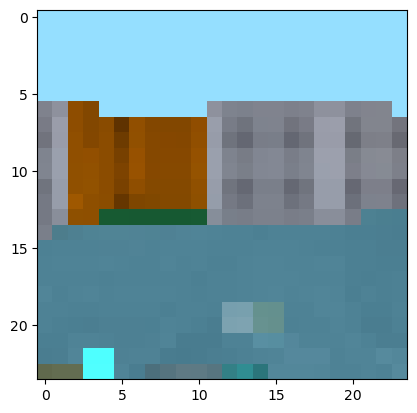

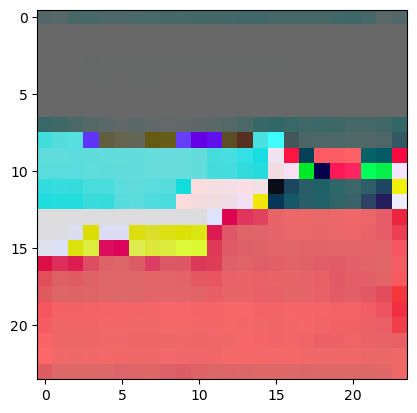

[0.00132161 0.00086843 0.00092987 0.00045009 0.00050457 0.00038236
 0.00105677 0.00144867 0.00044703 0.00043795 0.00166091 0.0006665
 0.0014515  0.00053869 0.00185469 0.00086927 0.00122468 0.00057399
 0.00061882 0.00138503 0.00056675 0.00044355 0.00098022 0.00103532
 0.00080081 0.00111291 0.00094451 0.00102826 0.00165605 0.00143599
 0.00046122 0.00122468 0.00161611 0.00053817 0.0013609  0.00105987
 0.00142621 0.0011393  0.00116404 0.00089424 0.00128973 0.00080867
 0.00082543 0.00080238 0.00143039 0.00052161 0.00150491 0.00044922
 0.00062489 0.00054133 0.00120923 0.00083028 0.00097069 0.00067435
 0.00216835 0.00086673 0.00059337 0.00105574 0.00096408 0.00089163
 0.00062428 0.0019801  0.00072915 0.00054504 0.0015618  0.00085999
 0.00088038 0.00108925 0.00102726 0.00119631 0.00076938 0.00085663
 0.00130876 0.00085663 0.00060685 0.00104446 0.00151671 0.00059628
 0.0016004  0.00107341 0.00115837 0.00150344 0.00133719 0.00158795
 0.00157252 0.00086589 0.00058303 0.00095192 0.00135031 0.00080

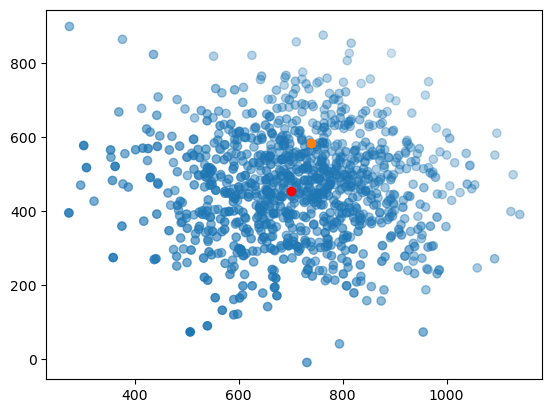

In [9]:
dpf.eval()
with torch.inference_mode():

    obs = data.observation[:, 0:1] 
    im = obs - torch.min(obs)
    im = im*(255/torch.max(im))
    im = im[25].reshape(3, 24, 24).permute((1,2,0))
    im = torch.roll(im, -3, -1)
    plt.imshow(im.to('cpu', dtype=torch.uint8).detach().numpy())
    plt.show()
    data_folder_path = pathlib.Path('.').parent.absolute().joinpath('data/')
    data1 = dict(np.load(data_folder_path.joinpath('maze_data_raw.npz'), allow_pickle=True))
    state = data.state[:, 0:1]
    control = data.control[:, 0:1]
    time = 99
    batch = 0
    dpf.update()
    encoded_obs = SSM.observation_model.encoder(obs.reshape(obs.size(0)*obs.size(1), 3, 24, 24))
    d_im = SSM.observation_model.decoder(encoded_obs)[25]
    d_im = d_im - torch.min(obs)
    d_im = d_im*(255/torch.max(obs))
    d_im = d_im.reshape(3, 24, 24).permute((1,2,0))
    plt.imshow(d_im.to('cpu', dtype=torch.uint8).detach().numpy())
    plt.show()
    ps = dpf(1000, 99, {'state': pydpf.State(), 'weight': pydpf.Weight()}, observation=encoded_obs.reshape(100, 1, encoded_obs.size(1)).contiguous(), ground_truth=state, control=control)
numpy_ps = ps['state'].detach().cpu().numpy()

numpy_weight = ps['weight'].detach().cpu().numpy()

numpy_weight_norm = np.exp(numpy_weight)[:,0,:]
print(numpy_weight_norm[0])
plt.scatter(numpy_ps[time,batch,:,0]*scaling, numpy_ps[time,batch,:,1]*scaling, alpha=np.exp(numpy_weight[time, batch, :] - np.max(numpy_weight[time, batch, :])))
plt.scatter(state.cpu().numpy()[time,batch,0]*scaling, state.cpu().numpy()[time,batch,1]*scaling)
plt.scatter(np.sum(numpy_ps[time,batch,:,0]*numpy_weight_norm[time], keepdims=True)*scaling, [np.sum(numpy_ps[time,batch,:,1]*numpy_weight_norm[time], keepdims=True)*scaling], color='red')

plt.show()